In [1]:
from functools import partial

import matplotlib.pyplot as plt

from superfv import EulerSolver, OutputLoader, plot_1d_slice
from superfv.initial_conditions import sedov
from teyssier.sedov import sedovana

In [2]:
N = 64
T = 0.8
gamma = 1.4

path = "../out/sedov2d/"
overwrite = ["ZS3", "MM3"]

configs = {
    "MUSCL-Hancock": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        p=1,
        MUSCL=True,
        MUSCL_limiter="moncen",
        SED=True,
    ),
    "ZS3": dict(
        GL=True,
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        ZS=True,
        include_corners=True,
        adaptive_dt=False,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
    "MM3": dict(
        riemann_solver="hllc",
        flux_recipe=2,
        lazy_primitives=True,
        p=3,
        MOOD=True,
        cascade="muscl",
        MUSCL_limiter="moncen",
        max_MOOD_iters=1,
        limiting_vars="actives",
        NAD=True,
        include_corners=True,
        NAD_rtol=1e-2,
        NAD_atol=1e-2,
        PAD={"rho": (0, None), "P": (0, None)},
        SED=True,
    ),
}

sims = {}
for name, config in configs.items():
    if overwrite != "all":
        if name not in overwrite:
            try:
                sim = OutputLoader(path + name)
                sims[name] = sim
                continue
            except FileNotFoundError:
                pass

    print(f"Running {name}...")
    sim = EulerSolver(
        ic=partial(sedov, P0=1e-5, h=1 / N, gamma=gamma),
        gamma=gamma,
        bcx=("reflective", "free"),
        bcy=("reflective", "free"),
        nx=N,
        ny=N,
        cupy=False,
        **config,
    )

    try:
        if config.get("MUSCL", False):
            sim.musclhancock(T, allow_overshoot=True, path=path + name, overwrite=True)
        else:
            sim.run(T, q_max=2, allow_overshoot=True, path=path + name, overwrite=True)
        sims[name] = sim
    except Exception as e:
        print(f"Failed: {e}")
        continue

Successfully read simulation output from "../out/sedov2d/MUSCL-Hancock"
Running ZS3...
Overwriting existing output directory "../out/sedov2d/ZS3".
Step #1091 @ t=8.00e-01 | dt=8.61e-04 | min(rho)=2.60e-03, min(P)=1.00e-05 | (done)                 
Running MM3...
Overwriting existing output directory "../out/sedov2d/MM3".
Step #1117 @ t=8.01e-01 | dt=8.38e-04 | min(rho)=2.45e-03, min(P)=1.00e-05 | (done)                 


In [3]:
# analytical solution for plotting
dim = 2
E0 = 1
rho0 = 1

r, d, u, P = sedovana(gamma, dim)

r *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (2 / (dim + 2))
d *= rho0
u *= (E0 / rho0) ** (1.0 / (dim + 2)) * T ** (-dim / (dim + 2))
P *= (E0 / rho0) ** (2.0 / (dim + 2)) * T ** (-2 * dim / (dim + 2)) * rho0

chi0=np.float64(1.0018778777154949)


/home/jp7427/Desktop/superfv/superfv/visualization.py:34: UserWarning: Cell-centered coordinate 0 not exactly matched in mesh; using nearest: 0.0078125
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:34: UserWarning: Cell-centered coordinate 0 not exactly matched in mesh; using nearest: 0.0078125
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:34: UserWarning: Cell-centered coordinate 0 not exactly matched in mesh; using nearest: 0.0078125
  warnings.warn(
/home/jp7427/Desktop/superfv/superfv/visualization.py:34: UserWarning: Cell-centered coordinate 0 not exactly matched in mesh; using nearest: 0.0078125
  warnings.warn(


(0.0, 1.0)

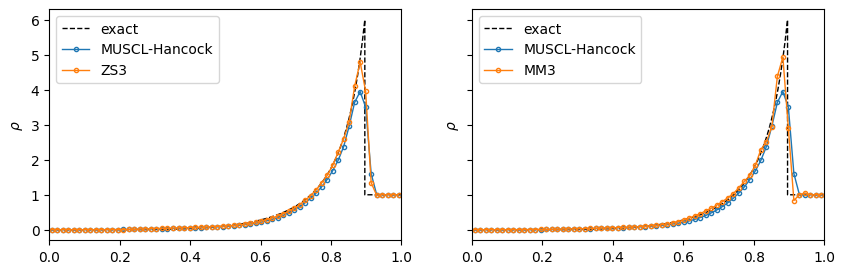

In [4]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey="row", figsize=(10, 3))

axs[0].set_ylabel(r"$\rho$")
axs[1].set_ylabel(r"$\rho$")
axs[0].set_xlim(0, 1)

style = dict(linewidth=1, markersize=3)

axs[0].plot(r, d, color="k", linestyle="--", label="exact", **style)
axs[1].plot(r, d, color="k", linestyle="--", label="exact", **style)

for name, sim in sims.items():
    MOOD = "MM" in name
    jlist = [0, 1] if name == "MUSCL-Hancock" else [1] if MOOD else [0]
    for j in jlist:
        plot_1d_slice(
            sim,
            axs[j],
            "rho",
            y=0,
            trouble_marker="o" if MOOD else None,
            label=name,
            marker="o",
            mfc="none",
            **style,
        )

axs[0].legend()
axs[1].legend()

axs[0].set_xlim(0, 1)